# WGAN with Conditional Normalizing Flow


In [4]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [1]:
import os
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LightSource
from IPython.display import clear_output
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import func.propagation as prop
import func.velmodel as vmod

device = 'gpu'
labelsize = 16

# from google.colab import drive
# drive.mount('/content/drive')

2023-12-04 14:36:07.761746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 14:36:08.121368: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 14:36:09.988653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-12-04 14:36:09.989141: W tensorflow/comp

## Load Dataset

2023-12-04 14:37:04.213228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-04 14:37:04.225131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-04 14:37:04.225660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-04 14:37:04.231694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(2816, 40, 120, 1)


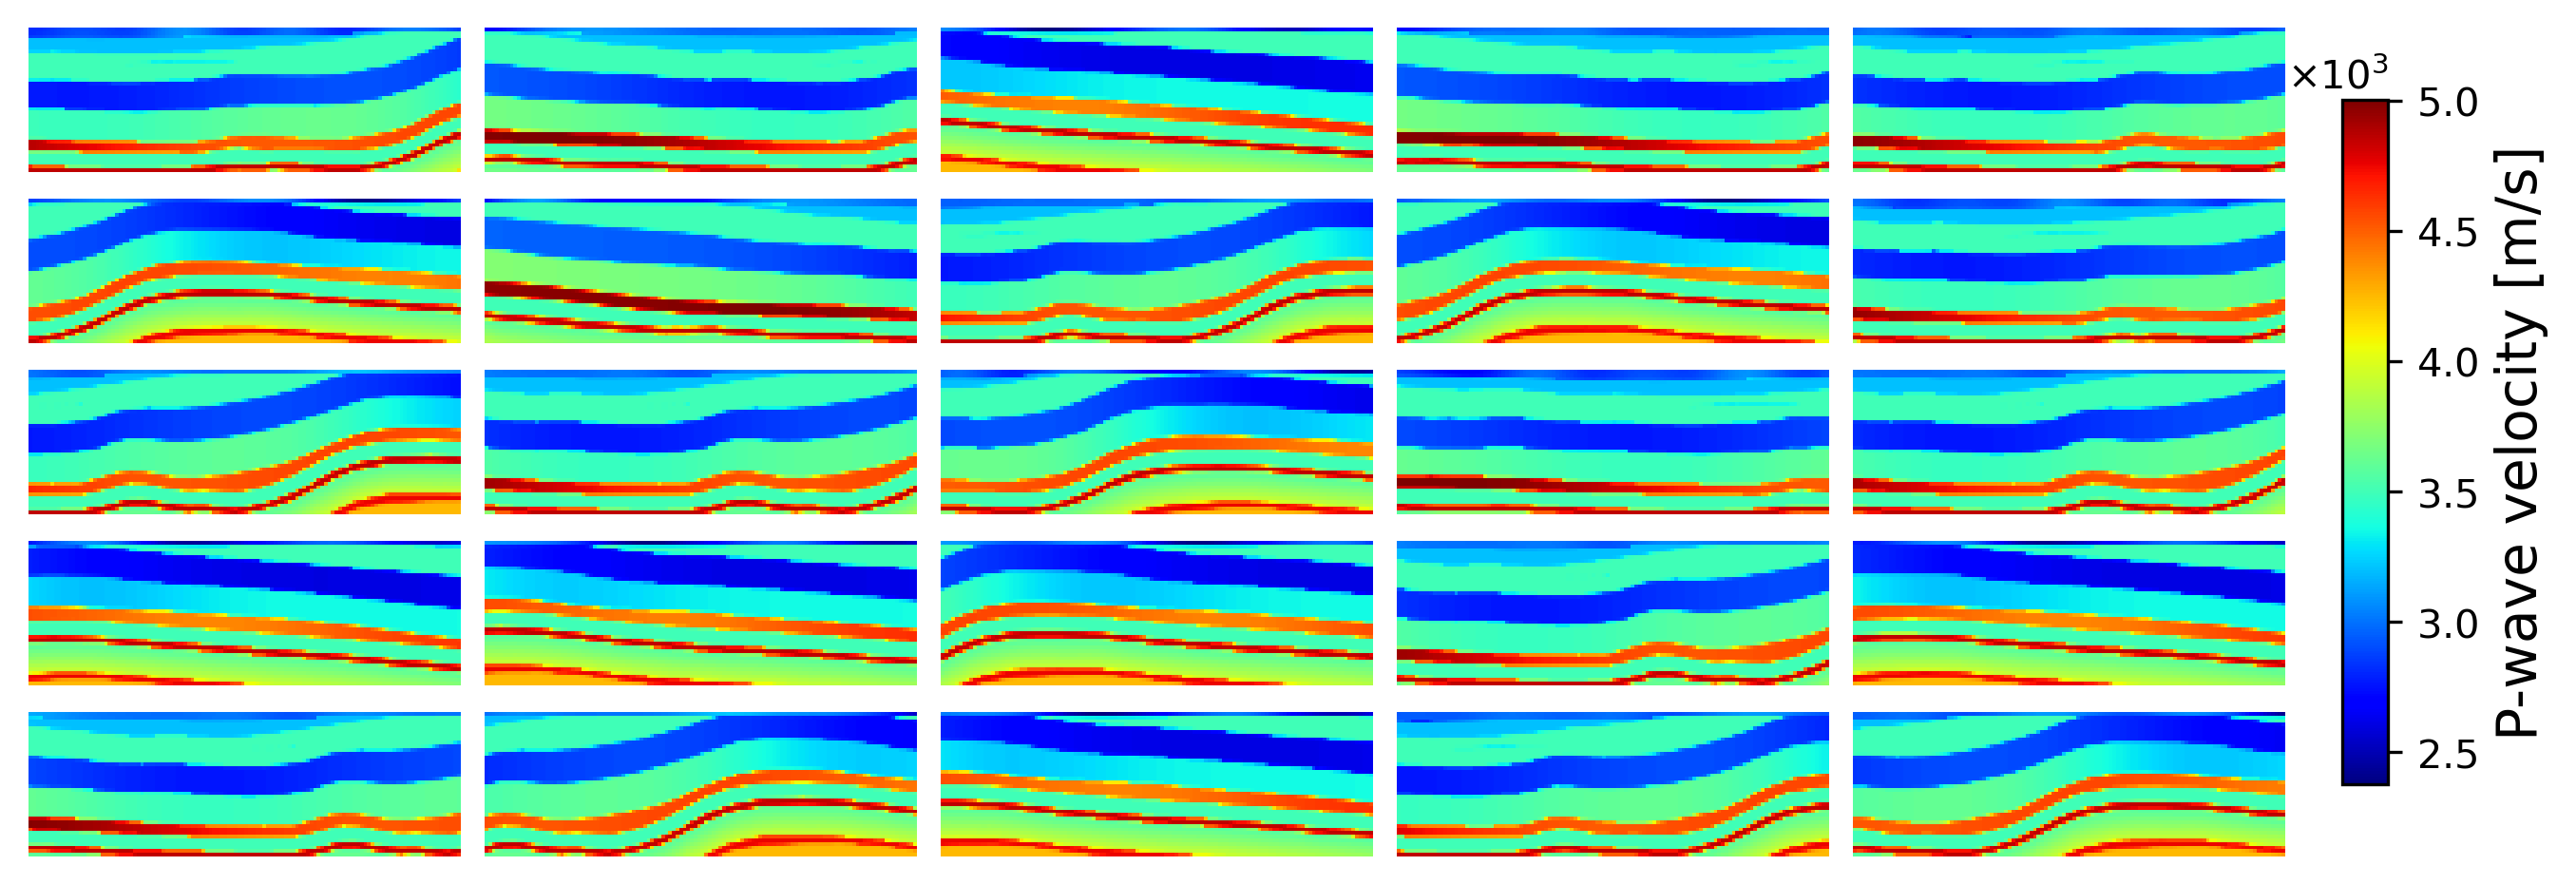

In [3]:
# n1=93 n2=401 n3=401 d1=d2=d3=50m
overthrust = vmod.readbin('../dataset/velocity/overthrust.bin',93,401*401)
# vel = vmod.readbin('/content/drive/MyDrive/yxieg/notebook/v.bin',93,401*401)
overthrust = np.reshape(overthrust,[93,401,401])
n = 120
vel = overthrust[:41, :, 60:70]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape
    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])
    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//8 # Interval on x-axis
y_interval = crop_size[1]//8  # Interval on y-axis

z_interval = 1  # Interval on z-axis
x_interval = 1 # Interval on x-axis
y_interval = 1  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')
cropped_images = cropped_images[:int(n_img - n_img%256),:,:,:]

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(8, 3), dpi=300, layout="constrained")
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([1.02, 0.1, 0.02, 0.8])  # [x, y, width, height]
cbar = plt.colorbar(cax=cax)
cbar.set_label("P-wave velocity [m/s]", fontsize=14)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
# Show the plot
# plt.tight_layout()
plt.show()


In [42]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 16
dim_z = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

-0.99999994 0.99999994


# Forward modeling

Min velocity: 2664.83  Max velocity 4850.00
dz,dx,dt (m): 9.504880859375 9.504880859375 0.0012094673270528794
Model dimension [nz,nx,nt]:  40 120 600


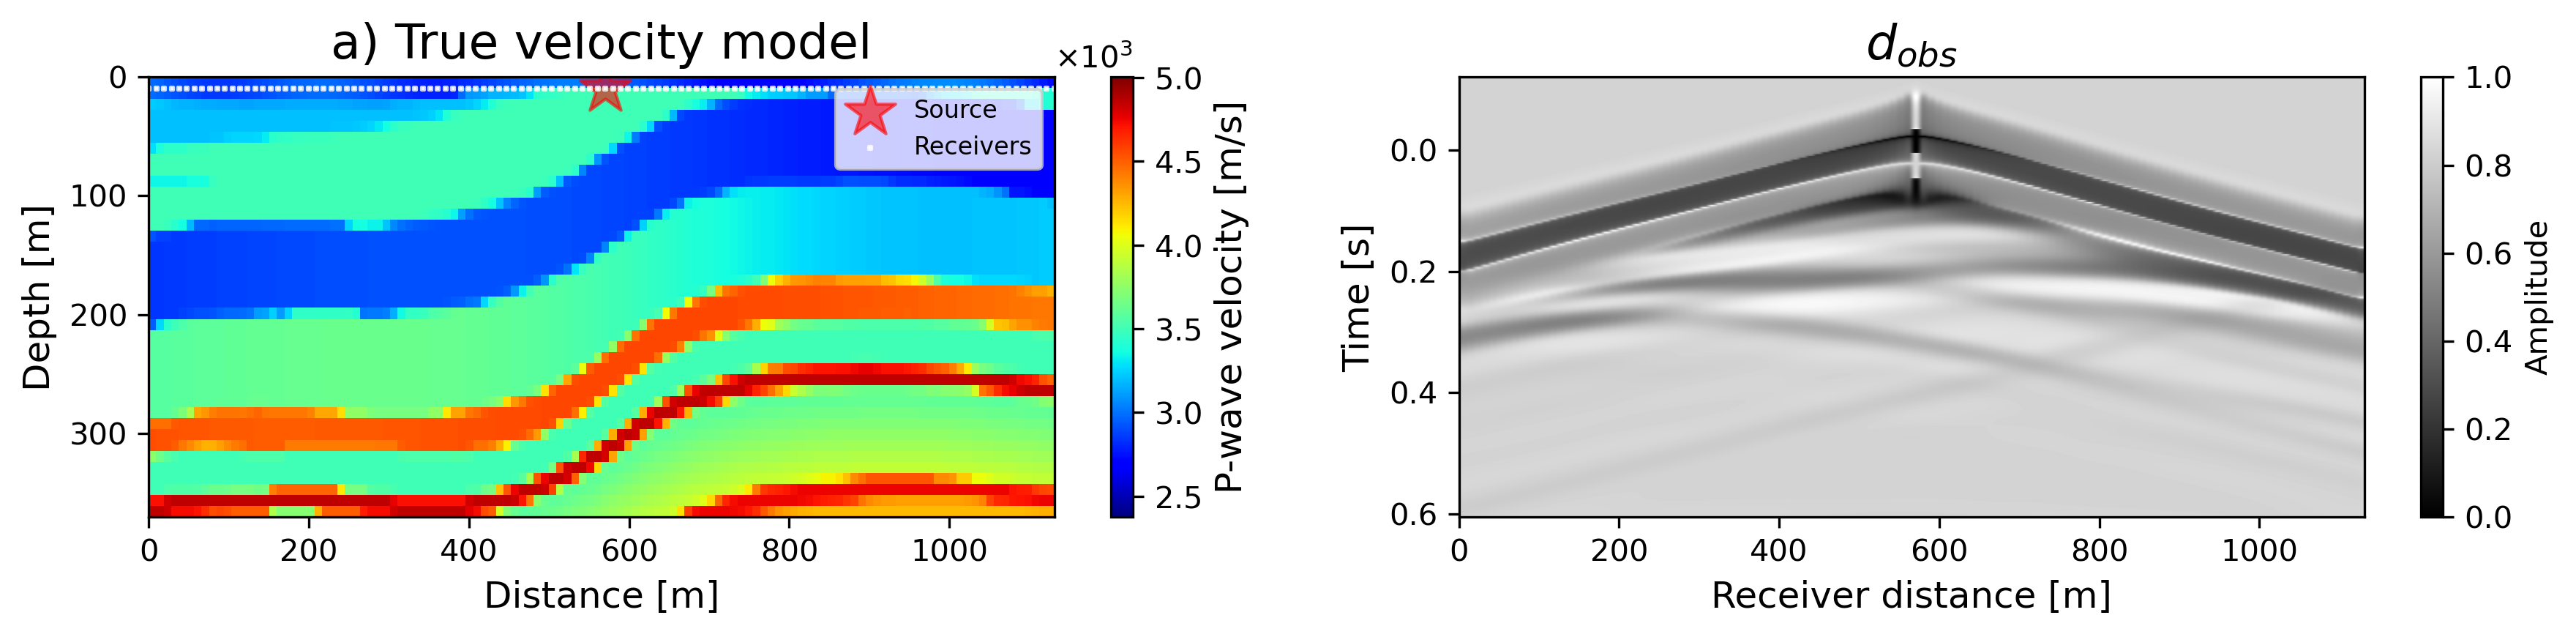

In [43]:
def disp_fwd(vel, d_obs):
	plt.figure(figsize=(12,3), dpi=300)
	plt.subplot(1,2,1)
	plt.imshow(vel.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("a) True velocity model",fontsize=labelsize)

	plt.subplot(1,2,2)
	seismic_data = tf.transpose(d_obs[0]).numpy()
	ls = LightSource(azdeg=180, altdeg=45)
	cmap = plt.cm.gist_earth
	hillshaded = ls.hillshade(seismic_data, vert_exag=20, fraction=1.0)
	plt.imshow(hillshaded, cmap='gray',
						vmin=0,vmax=1,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	# plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.set_label("Amplitude")
	plt.title("$d_{obs}$", fontsize=labelsize)
	plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
	plt.ylabel('Time [s]', fontsize=labelsize-4)
	plt.tight_layout()
	plt.show()


# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,600
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

# v_ref = cropped_images[860,:,:,0].numpy()
v_ref = cropped_images[170,:,:,0].numpy()
# v_ref = cropped_images[700,:,:,0].numpy()

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = prop.defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]

# Set sourse and receiver coordinates: shape=(2,nrec)
zxsrc = np.array([[1], [3*nx//6]]) # Single Sourse
# zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
zxrec = np.vstack((np.ones(nx), np.arange(0,nx))).astype(int) # Receivers everywhere at top

nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop.prop2d(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next, device)
  d_obs.append(d_obs_i)

disp_fwd(v_ref, d_obs)

In [8]:
@tf.custom_gradient
def dJ_dm(vel):
  loss_J = prop.misfit(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
  loss_J = tf.cast(loss_J, tf.float32)

  def grad_fn(upstream):
    grad = prop.adjoint_gradient(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    return upstream * tf.cast(grad, tf.float32)
  return loss_J, grad_fn

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

## Define Generator and Discriminator

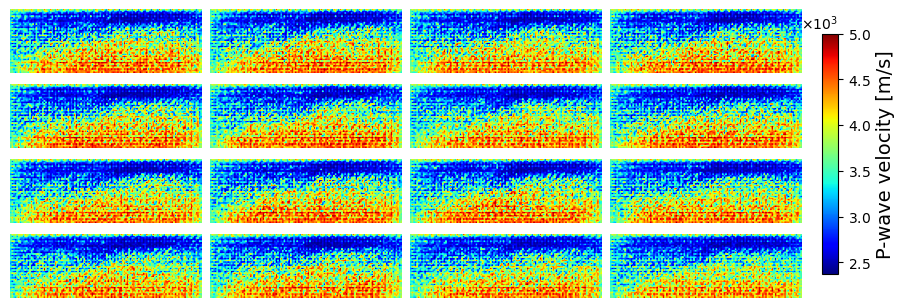

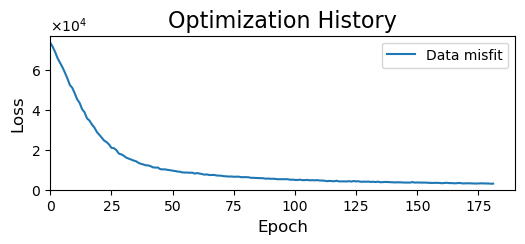

InternalError: Failed to load in-memory CUBIN: CUDA_ERROR_OUT_OF_MEMORY: out of memory [Op:__inference__update_step_xla_499384]

In [59]:
kernal_size = (5, 5)
kernal_size_2 = (7, 7)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(PixelShuffle(scale=2))  # Add Pixel Shuffle with scale 2

    model.add(layers.Conv2DTranspose(256, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

new_training = 0
if new_training==True:
  generator = make_generator_model()
  loss_history = []

for i in range(50000):
  noise = tf.random.normal([BATCH_SIZE, dim_z])
  with tf.GradientTape() as tape:
    generated = generator(noise, training=True)
    loss = []
    for i in range(generated.shape[0]):
      Gz = inverse_norm(generated[i,:,:,0],vmin,vmax)
      m = tf.reshape(Gz, -1)
      # Forward propagation & Adjoint back propagation
      J = dJ_dm(m)
      loss.append(J)
    loss = tf.reduce_mean(loss)
    loss_history.append(loss)
      
  gradients_of_generator = tape.gradient(loss, generator.trainable_variables)
  generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  clear_output(wait=True)
  fig = plt.figure(figsize=(8, 3), dpi=100, layout="constrained")
  for j in range(16):
    plt.subplot(4, 4, j+1)
    Gz_i = inverse_norm(generated[j,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')
  # Add a single colorbar for all subplots
  cax = plt.axes([1.02, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  # Show the plot
  # plt.tight_layout()
  plt.show()

  plt.figure(figsize=(6, 2), dpi=100)
  plt.plot(loss_history,lw=1.5)
  # Set the x-axis tick formatter to scientific notation
  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.legend(['Data misfit'])
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlabel('Epoch', fontsize=labelsize-4)
  plt.ylabel('Loss', fontsize=labelsize-4)
  plt.title("Optimization History",fontsize=labelsize)
  plt.show()
  